# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

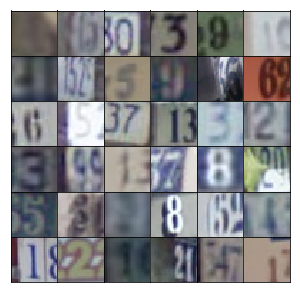

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer, 
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=alpha)
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002 # 0.001
batch_size = 128  # 64
epochs = 25  # 1
alpha = 0.2  # 0.01
beta1 = 0.5  # 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 0.5389... Generator Loss: 1.9287
Epoch 1/25... Discriminator Loss: 0.1811... Generator Loss: 2.8600
Epoch 1/25... Discriminator Loss: 0.1205... Generator Loss: 3.0851
Epoch 1/25... Discriminator Loss: 0.4648... Generator Loss: 1.3428
Epoch 1/25... Discriminator Loss: 1.8327... Generator Loss: 6.1470
Epoch 1/25... Discriminator Loss: 0.3815... Generator Loss: 4.2265
Epoch 1/25... Discriminator Loss: 0.1856... Generator Loss: 2.8644
Epoch 1/25... Discriminator Loss: 0.2092... Generator Loss: 2.7502
Epoch 1/25... Discriminator Loss: 0.2329... Generator Loss: 2.6817
Epoch 1/25... Discriminator Loss: 0.2198... Generator Loss: 2.4884


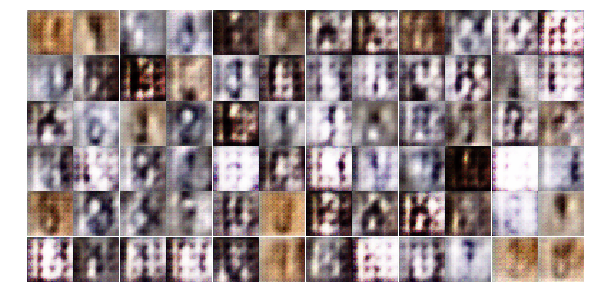

Epoch 1/25... Discriminator Loss: 0.2321... Generator Loss: 3.1372
Epoch 2/25... Discriminator Loss: 0.4654... Generator Loss: 1.3885
Epoch 2/25... Discriminator Loss: 0.7857... Generator Loss: 1.2818
Epoch 2/25... Discriminator Loss: 0.4733... Generator Loss: 1.7646
Epoch 2/25... Discriminator Loss: 1.3498... Generator Loss: 2.7952
Epoch 2/25... Discriminator Loss: 0.8310... Generator Loss: 0.9291
Epoch 2/25... Discriminator Loss: 0.7981... Generator Loss: 2.4874
Epoch 2/25... Discriminator Loss: 0.8027... Generator Loss: 1.2995
Epoch 2/25... Discriminator Loss: 1.0063... Generator Loss: 3.0561
Epoch 2/25... Discriminator Loss: 0.9580... Generator Loss: 2.5905


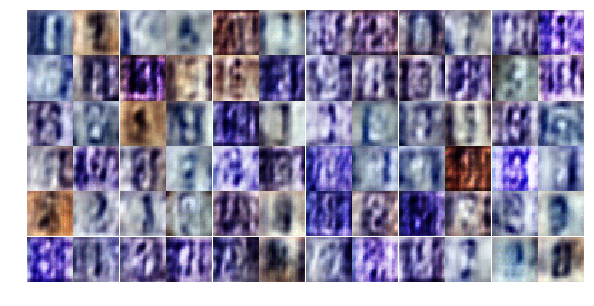

Epoch 2/25... Discriminator Loss: 0.7936... Generator Loss: 1.6020
Epoch 2/25... Discriminator Loss: 1.0001... Generator Loss: 2.1305
Epoch 3/25... Discriminator Loss: 0.6322... Generator Loss: 1.8982
Epoch 3/25... Discriminator Loss: 0.6907... Generator Loss: 1.4511
Epoch 3/25... Discriminator Loss: 1.0328... Generator Loss: 0.5966
Epoch 3/25... Discriminator Loss: 0.3885... Generator Loss: 1.9357
Epoch 3/25... Discriminator Loss: 0.7121... Generator Loss: 1.0870
Epoch 3/25... Discriminator Loss: 0.6651... Generator Loss: 1.3411
Epoch 3/25... Discriminator Loss: 2.0382... Generator Loss: 0.2076
Epoch 3/25... Discriminator Loss: 0.5313... Generator Loss: 1.4982


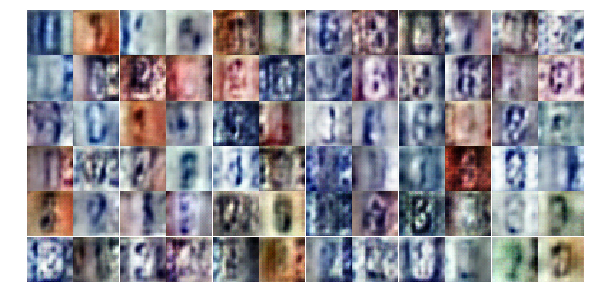

Epoch 3/25... Discriminator Loss: 0.4864... Generator Loss: 1.7583
Epoch 3/25... Discriminator Loss: 1.1967... Generator Loss: 0.5882
Epoch 3/25... Discriminator Loss: 0.5295... Generator Loss: 2.4016
Epoch 3/25... Discriminator Loss: 0.4033... Generator Loss: 2.1076
Epoch 4/25... Discriminator Loss: 0.5827... Generator Loss: 2.0241
Epoch 4/25... Discriminator Loss: 0.4435... Generator Loss: 1.6191
Epoch 4/25... Discriminator Loss: 0.8198... Generator Loss: 2.5505
Epoch 4/25... Discriminator Loss: 0.3784... Generator Loss: 2.5979
Epoch 4/25... Discriminator Loss: 0.5420... Generator Loss: 1.1925
Epoch 4/25... Discriminator Loss: 0.7691... Generator Loss: 0.9696


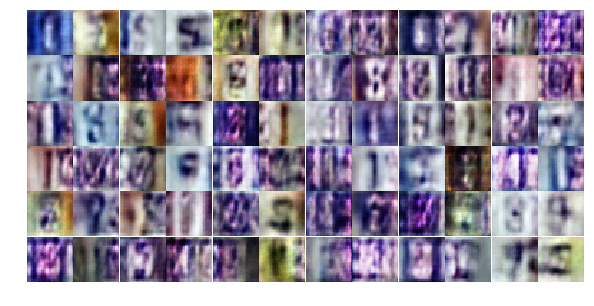

Epoch 4/25... Discriminator Loss: 0.3353... Generator Loss: 2.1813
Epoch 4/25... Discriminator Loss: 0.3652... Generator Loss: 2.0878
Epoch 4/25... Discriminator Loss: 0.2760... Generator Loss: 2.2418
Epoch 4/25... Discriminator Loss: 0.3428... Generator Loss: 2.2310
Epoch 4/25... Discriminator Loss: 0.3608... Generator Loss: 2.1458
Epoch 5/25... Discriminator Loss: 0.3059... Generator Loss: 2.6249
Epoch 5/25... Discriminator Loss: 0.2567... Generator Loss: 2.0339
Epoch 5/25... Discriminator Loss: 0.5072... Generator Loss: 1.2691
Epoch 5/25... Discriminator Loss: 0.7513... Generator Loss: 1.1930
Epoch 5/25... Discriminator Loss: 0.2562... Generator Loss: 2.3938


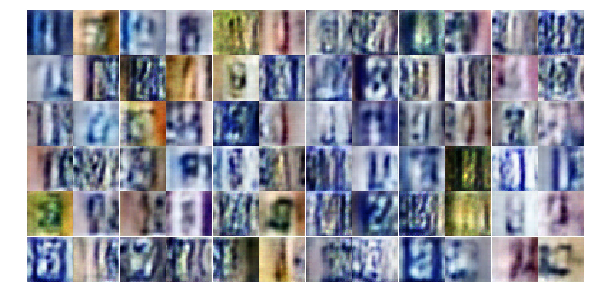

Epoch 5/25... Discriminator Loss: 0.5158... Generator Loss: 1.3213
Epoch 5/25... Discriminator Loss: 0.3885... Generator Loss: 1.5492
Epoch 5/25... Discriminator Loss: 0.4051... Generator Loss: 1.9926
Epoch 5/25... Discriminator Loss: 0.4125... Generator Loss: 1.5058
Epoch 5/25... Discriminator Loss: 0.3783... Generator Loss: 1.9561
Epoch 5/25... Discriminator Loss: 0.2452... Generator Loss: 2.4221
Epoch 5/25... Discriminator Loss: 0.3223... Generator Loss: 2.4842
Epoch 6/25... Discriminator Loss: 0.5294... Generator Loss: 1.2363
Epoch 6/25... Discriminator Loss: 0.3269... Generator Loss: 1.7652
Epoch 6/25... Discriminator Loss: 0.6598... Generator Loss: 3.2522


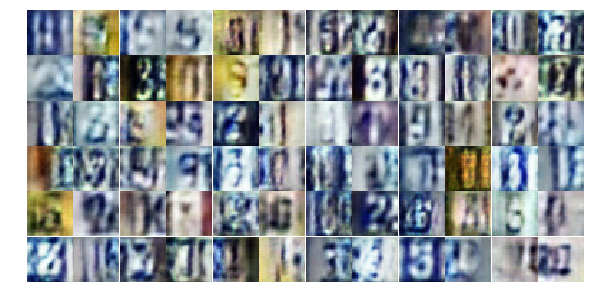

Epoch 6/25... Discriminator Loss: 0.1579... Generator Loss: 2.8805
Epoch 6/25... Discriminator Loss: 0.4822... Generator Loss: 1.5709
Epoch 6/25... Discriminator Loss: 0.2907... Generator Loss: 1.8817
Epoch 6/25... Discriminator Loss: 0.2760... Generator Loss: 1.9924
Epoch 6/25... Discriminator Loss: 0.3947... Generator Loss: 2.0559
Epoch 6/25... Discriminator Loss: 0.5628... Generator Loss: 1.1150
Epoch 6/25... Discriminator Loss: 0.4123... Generator Loss: 3.0752
Epoch 6/25... Discriminator Loss: 1.1645... Generator Loss: 0.5311
Epoch 7/25... Discriminator Loss: 1.2044... Generator Loss: 0.7129
Epoch 7/25... Discriminator Loss: 0.5510... Generator Loss: 1.2732


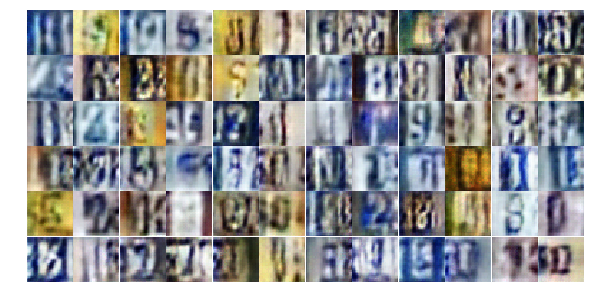

Epoch 7/25... Discriminator Loss: 0.3800... Generator Loss: 3.2598
Epoch 7/25... Discriminator Loss: 0.3500... Generator Loss: 1.8383
Epoch 7/25... Discriminator Loss: 0.3175... Generator Loss: 1.9342
Epoch 7/25... Discriminator Loss: 0.2785... Generator Loss: 2.3675
Epoch 7/25... Discriminator Loss: 0.3677... Generator Loss: 1.6117
Epoch 7/25... Discriminator Loss: 0.4848... Generator Loss: 3.9896
Epoch 7/25... Discriminator Loss: 0.5998... Generator Loss: 3.1597
Epoch 7/25... Discriminator Loss: 2.1423... Generator Loss: 4.7877
Epoch 7/25... Discriminator Loss: 0.6221... Generator Loss: 1.0954
Epoch 7/25... Discriminator Loss: 0.2349... Generator Loss: 2.2093


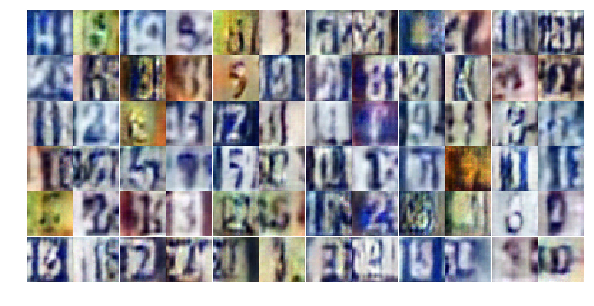

Epoch 8/25... Discriminator Loss: 0.3487... Generator Loss: 1.7526
Epoch 8/25... Discriminator Loss: 0.3556... Generator Loss: 1.5981
Epoch 8/25... Discriminator Loss: 0.6636... Generator Loss: 1.2808
Epoch 8/25... Discriminator Loss: 0.8054... Generator Loss: 0.8434
Epoch 8/25... Discriminator Loss: 0.3383... Generator Loss: 1.7167
Epoch 8/25... Discriminator Loss: 0.2291... Generator Loss: 2.1642
Epoch 8/25... Discriminator Loss: 0.6981... Generator Loss: 0.9871
Epoch 8/25... Discriminator Loss: 0.3023... Generator Loss: 1.9143
Epoch 8/25... Discriminator Loss: 3.4359... Generator Loss: 5.7957
Epoch 8/25... Discriminator Loss: 0.5454... Generator Loss: 1.9511


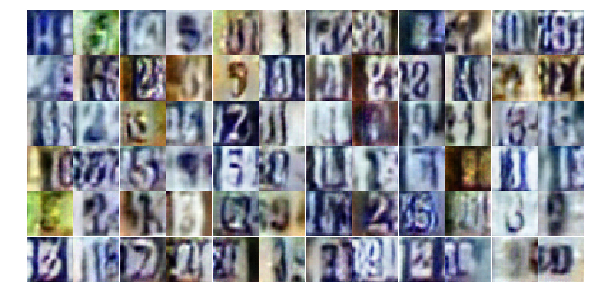

Epoch 8/25... Discriminator Loss: 0.2801... Generator Loss: 2.9768
Epoch 9/25... Discriminator Loss: 0.6940... Generator Loss: 0.9523
Epoch 9/25... Discriminator Loss: 0.9693... Generator Loss: 0.6985
Epoch 9/25... Discriminator Loss: 0.4054... Generator Loss: 1.6612
Epoch 9/25... Discriminator Loss: 0.3403... Generator Loss: 2.7009
Epoch 9/25... Discriminator Loss: 0.6202... Generator Loss: 1.4035
Epoch 9/25... Discriminator Loss: 0.3508... Generator Loss: 2.3503
Epoch 9/25... Discriminator Loss: 0.4539... Generator Loss: 1.4022
Epoch 9/25... Discriminator Loss: 0.3270... Generator Loss: 2.0033
Epoch 9/25... Discriminator Loss: 0.3689... Generator Loss: 1.5563


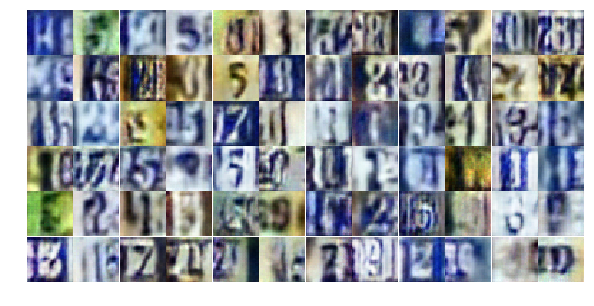

Epoch 9/25... Discriminator Loss: 0.2008... Generator Loss: 2.6973
Epoch 9/25... Discriminator Loss: 0.2887... Generator Loss: 2.0496
Epoch 9/25... Discriminator Loss: 0.3836... Generator Loss: 1.6423
Epoch 10/25... Discriminator Loss: 0.9123... Generator Loss: 0.6589
Epoch 10/25... Discriminator Loss: 0.3878... Generator Loss: 1.6988
Epoch 10/25... Discriminator Loss: 0.4150... Generator Loss: 2.0616
Epoch 10/25... Discriminator Loss: 0.4555... Generator Loss: 1.4091
Epoch 10/25... Discriminator Loss: 0.1883... Generator Loss: 2.4343
Epoch 10/25... Discriminator Loss: 0.5010... Generator Loss: 1.2211
Epoch 10/25... Discriminator Loss: 0.4959... Generator Loss: 1.2898


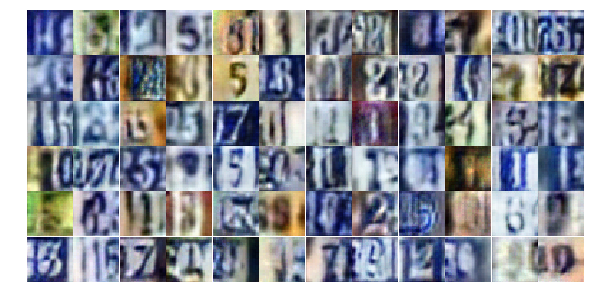

Epoch 10/25... Discriminator Loss: 0.8323... Generator Loss: 0.8538
Epoch 10/25... Discriminator Loss: 0.6367... Generator Loss: 3.9117
Epoch 10/25... Discriminator Loss: 0.3170... Generator Loss: 2.5969
Epoch 10/25... Discriminator Loss: 0.4044... Generator Loss: 2.7323
Epoch 11/25... Discriminator Loss: 0.4505... Generator Loss: 1.3953
Epoch 11/25... Discriminator Loss: 0.2379... Generator Loss: 2.1409
Epoch 11/25... Discriminator Loss: 0.4954... Generator Loss: 1.2604
Epoch 11/25... Discriminator Loss: 1.1272... Generator Loss: 0.6083
Epoch 11/25... Discriminator Loss: 0.2902... Generator Loss: 2.2017
Epoch 11/25... Discriminator Loss: 0.4004... Generator Loss: 1.5536


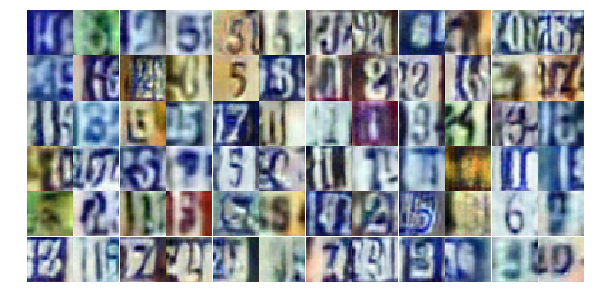

Epoch 11/25... Discriminator Loss: 0.3391... Generator Loss: 1.6823
Epoch 11/25... Discriminator Loss: 1.0498... Generator Loss: 0.6184
Epoch 11/25... Discriminator Loss: 0.7632... Generator Loss: 0.8381
Epoch 11/25... Discriminator Loss: 0.4037... Generator Loss: 1.7716
Epoch 11/25... Discriminator Loss: 0.6895... Generator Loss: 1.0224
Epoch 11/25... Discriminator Loss: 0.6663... Generator Loss: 1.0431
Epoch 12/25... Discriminator Loss: 0.2587... Generator Loss: 2.0699
Epoch 12/25... Discriminator Loss: 1.2260... Generator Loss: 0.5947
Epoch 12/25... Discriminator Loss: 0.2367... Generator Loss: 2.2394
Epoch 12/25... Discriminator Loss: 0.5108... Generator Loss: 1.4693


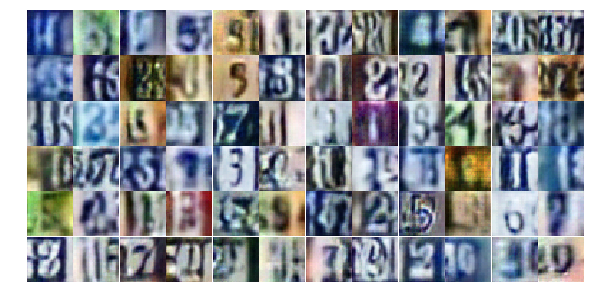

Epoch 12/25... Discriminator Loss: 0.2196... Generator Loss: 2.5665
Epoch 12/25... Discriminator Loss: 0.4668... Generator Loss: 1.3579
Epoch 12/25... Discriminator Loss: 0.3625... Generator Loss: 2.1822
Epoch 12/25... Discriminator Loss: 0.2130... Generator Loss: 2.1400
Epoch 12/25... Discriminator Loss: 2.1050... Generator Loss: 0.2911
Epoch 12/25... Discriminator Loss: 0.5631... Generator Loss: 1.1723
Epoch 12/25... Discriminator Loss: 0.3815... Generator Loss: 1.5509
Epoch 13/25... Discriminator Loss: 0.5272... Generator Loss: 1.2643
Epoch 13/25... Discriminator Loss: 0.4352... Generator Loss: 1.5199
Epoch 13/25... Discriminator Loss: 0.4011... Generator Loss: 1.4003


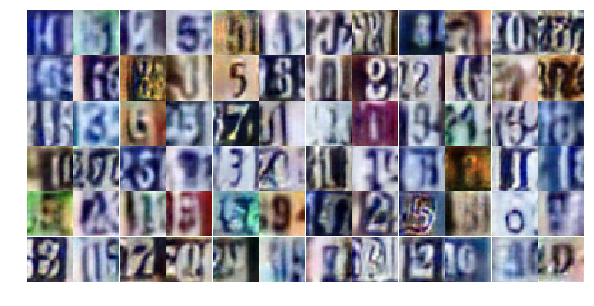

Epoch 13/25... Discriminator Loss: 0.3080... Generator Loss: 2.4781
Epoch 13/25... Discriminator Loss: 0.6042... Generator Loss: 1.0606
Epoch 13/25... Discriminator Loss: 0.4565... Generator Loss: 1.6354
Epoch 13/25... Discriminator Loss: 0.3069... Generator Loss: 2.1123
Epoch 13/25... Discriminator Loss: 0.2505... Generator Loss: 2.3679
Epoch 13/25... Discriminator Loss: 0.4690... Generator Loss: 1.2519
Epoch 13/25... Discriminator Loss: 0.7255... Generator Loss: 0.9101
Epoch 13/25... Discriminator Loss: 0.8964... Generator Loss: 0.7523
Epoch 14/25... Discriminator Loss: 0.5499... Generator Loss: 1.2311
Epoch 14/25... Discriminator Loss: 0.7762... Generator Loss: 0.8356


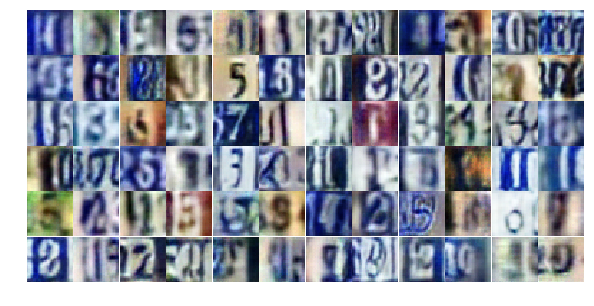

Epoch 14/25... Discriminator Loss: 0.9263... Generator Loss: 0.6821
Epoch 14/25... Discriminator Loss: 0.8708... Generator Loss: 0.8022
Epoch 14/25... Discriminator Loss: 0.7503... Generator Loss: 0.9140
Epoch 14/25... Discriminator Loss: 0.4643... Generator Loss: 3.0429
Epoch 14/25... Discriminator Loss: 0.3862... Generator Loss: 1.6386
Epoch 14/25... Discriminator Loss: 0.2993... Generator Loss: 2.0268
Epoch 14/25... Discriminator Loss: 0.6372... Generator Loss: 0.9783
Epoch 14/25... Discriminator Loss: 4.2619... Generator Loss: 5.1397
Epoch 14/25... Discriminator Loss: 0.4547... Generator Loss: 1.6184
Epoch 14/25... Discriminator Loss: 0.5651... Generator Loss: 1.1373


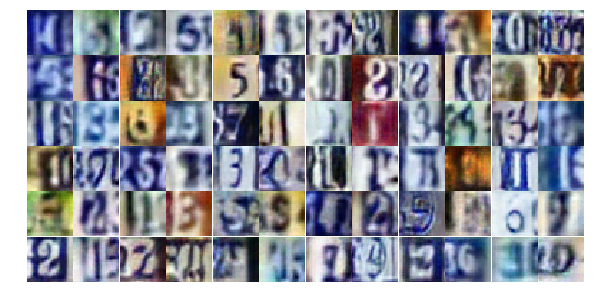

Epoch 15/25... Discriminator Loss: 0.4472... Generator Loss: 1.3733
Epoch 15/25... Discriminator Loss: 0.3204... Generator Loss: 1.8412
Epoch 15/25... Discriminator Loss: 0.5120... Generator Loss: 1.2785
Epoch 15/25... Discriminator Loss: 1.0082... Generator Loss: 0.6774
Epoch 15/25... Discriminator Loss: 0.7932... Generator Loss: 0.8493
Epoch 15/25... Discriminator Loss: 0.8567... Generator Loss: 0.8192
Epoch 15/25... Discriminator Loss: 0.4153... Generator Loss: 2.2367
Epoch 15/25... Discriminator Loss: 0.2840... Generator Loss: 2.0917
Epoch 15/25... Discriminator Loss: 0.3796... Generator Loss: 1.5529
Epoch 15/25... Discriminator Loss: 0.5292... Generator Loss: 1.4192


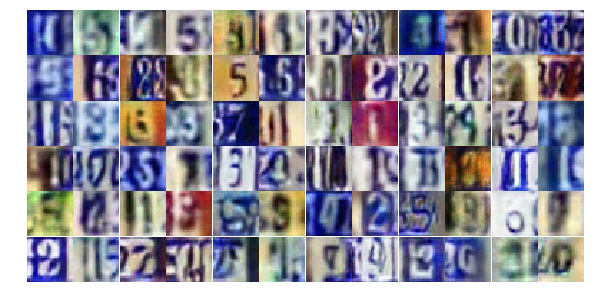

Epoch 15/25... Discriminator Loss: 0.3571... Generator Loss: 1.8999
Epoch 16/25... Discriminator Loss: 0.7503... Generator Loss: 0.8288
Epoch 16/25... Discriminator Loss: 0.2949... Generator Loss: 2.6163
Epoch 16/25... Discriminator Loss: 0.3531... Generator Loss: 1.6184
Epoch 16/25... Discriminator Loss: 0.3562... Generator Loss: 1.5917
Epoch 16/25... Discriminator Loss: 0.3377... Generator Loss: 3.2810
Epoch 16/25... Discriminator Loss: 0.3607... Generator Loss: 2.1525
Epoch 16/25... Discriminator Loss: 0.4466... Generator Loss: 1.5351
Epoch 16/25... Discriminator Loss: 0.9624... Generator Loss: 0.7770
Epoch 16/25... Discriminator Loss: 0.3345... Generator Loss: 1.7134


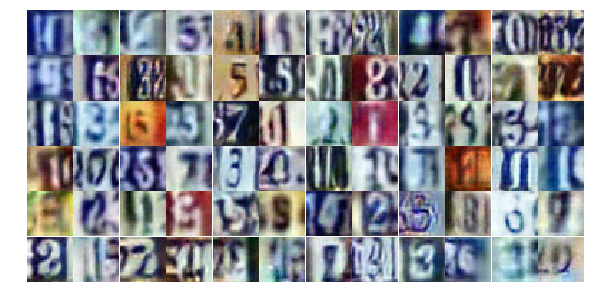

Epoch 16/25... Discriminator Loss: 0.9776... Generator Loss: 0.6493
Epoch 16/25... Discriminator Loss: 0.5268... Generator Loss: 1.3485
Epoch 16/25... Discriminator Loss: 0.3019... Generator Loss: 1.8854
Epoch 17/25... Discriminator Loss: 0.4964... Generator Loss: 1.5692
Epoch 17/25... Discriminator Loss: 0.4759... Generator Loss: 1.4156
Epoch 17/25... Discriminator Loss: 0.3257... Generator Loss: 1.9057
Epoch 17/25... Discriminator Loss: 0.5842... Generator Loss: 1.2793
Epoch 17/25... Discriminator Loss: 0.3540... Generator Loss: 1.5850
Epoch 17/25... Discriminator Loss: 0.6544... Generator Loss: 1.0058
Epoch 17/25... Discriminator Loss: 0.3030... Generator Loss: 1.9220


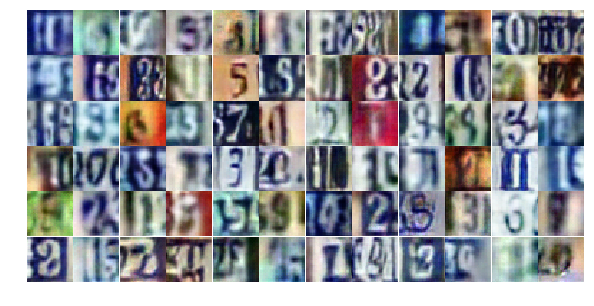

Epoch 17/25... Discriminator Loss: 0.7697... Generator Loss: 0.8583
Epoch 17/25... Discriminator Loss: 0.3728... Generator Loss: 1.5722
Epoch 17/25... Discriminator Loss: 0.4995... Generator Loss: 1.3556
Epoch 17/25... Discriminator Loss: 0.7349... Generator Loss: 1.0395
Epoch 18/25... Discriminator Loss: 0.7595... Generator Loss: 0.9925
Epoch 18/25... Discriminator Loss: 1.0891... Generator Loss: 0.7148
Epoch 18/25... Discriminator Loss: 0.2807... Generator Loss: 1.9053
Epoch 18/25... Discriminator Loss: 0.2100... Generator Loss: 3.5853
Epoch 18/25... Discriminator Loss: 0.4461... Generator Loss: 1.2770
Epoch 18/25... Discriminator Loss: 0.4910... Generator Loss: 1.3570


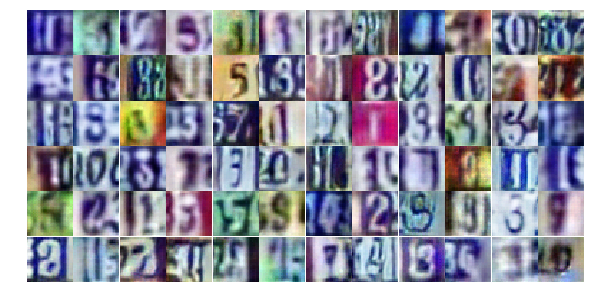

Epoch 18/25... Discriminator Loss: 1.1472... Generator Loss: 0.6191
Epoch 18/25... Discriminator Loss: 0.3639... Generator Loss: 1.8528
Epoch 18/25... Discriminator Loss: 0.7330... Generator Loss: 0.9085
Epoch 18/25... Discriminator Loss: 0.3226... Generator Loss: 2.2100
Epoch 18/25... Discriminator Loss: 0.4238... Generator Loss: 1.5856
Epoch 18/25... Discriminator Loss: 0.9986... Generator Loss: 0.7016
Epoch 19/25... Discriminator Loss: 0.8554... Generator Loss: 4.7632
Epoch 19/25... Discriminator Loss: 0.6640... Generator Loss: 1.1130
Epoch 19/25... Discriminator Loss: 0.5590... Generator Loss: 1.2390
Epoch 19/25... Discriminator Loss: 0.4827... Generator Loss: 1.5309


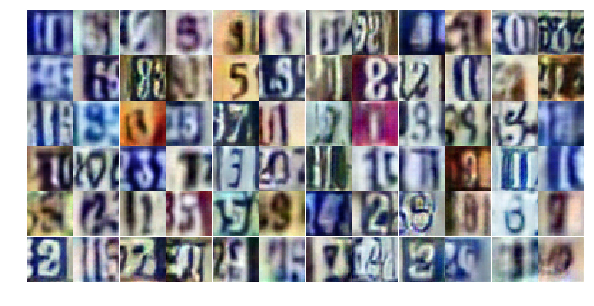

Epoch 19/25... Discriminator Loss: 1.1394... Generator Loss: 0.5711
Epoch 19/25... Discriminator Loss: 0.7167... Generator Loss: 1.0303
Epoch 19/25... Discriminator Loss: 0.3951... Generator Loss: 1.5636
Epoch 19/25... Discriminator Loss: 0.3853... Generator Loss: 1.6017
Epoch 19/25... Discriminator Loss: 0.4268... Generator Loss: 1.6398
Epoch 19/25... Discriminator Loss: 0.6046... Generator Loss: 1.1584
Epoch 19/25... Discriminator Loss: 0.6644... Generator Loss: 1.0646
Epoch 20/25... Discriminator Loss: 0.4346... Generator Loss: 1.7878
Epoch 20/25... Discriminator Loss: 0.8385... Generator Loss: 4.7290
Epoch 20/25... Discriminator Loss: 0.4644... Generator Loss: 1.2578


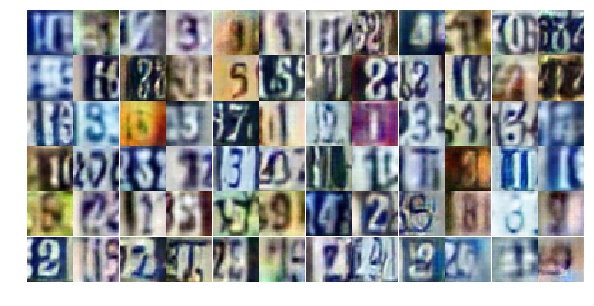

Epoch 20/25... Discriminator Loss: 0.5618... Generator Loss: 1.1554
Epoch 20/25... Discriminator Loss: 0.5318... Generator Loss: 1.1977
Epoch 20/25... Discriminator Loss: 0.4681... Generator Loss: 2.3021
Epoch 20/25... Discriminator Loss: 0.3316... Generator Loss: 1.6838
Epoch 20/25... Discriminator Loss: 0.4202... Generator Loss: 1.6618
Epoch 20/25... Discriminator Loss: 0.8445... Generator Loss: 0.8154
Epoch 20/25... Discriminator Loss: 0.4456... Generator Loss: 1.5805
Epoch 20/25... Discriminator Loss: 0.4170... Generator Loss: 1.5079
Epoch 20/25... Discriminator Loss: 0.4146... Generator Loss: 1.6291
Epoch 21/25... Discriminator Loss: 0.7167... Generator Loss: 1.0301


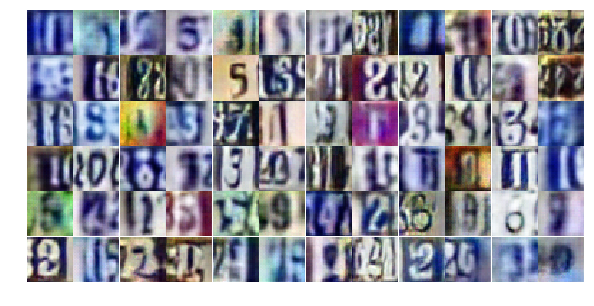

Epoch 21/25... Discriminator Loss: 0.4968... Generator Loss: 1.4102
Epoch 21/25... Discriminator Loss: 0.6358... Generator Loss: 1.1295
Epoch 21/25... Discriminator Loss: 0.3175... Generator Loss: 2.5540
Epoch 21/25... Discriminator Loss: 0.6309... Generator Loss: 1.0679
Epoch 21/25... Discriminator Loss: 0.3942... Generator Loss: 1.8013
Epoch 21/25... Discriminator Loss: 1.5172... Generator Loss: 0.4843
Epoch 21/25... Discriminator Loss: 0.6736... Generator Loss: 1.0562
Epoch 21/25... Discriminator Loss: 0.1123... Generator Loss: 4.1759
Epoch 21/25... Discriminator Loss: 0.2542... Generator Loss: 1.9281
Epoch 21/25... Discriminator Loss: 0.2162... Generator Loss: 2.4218


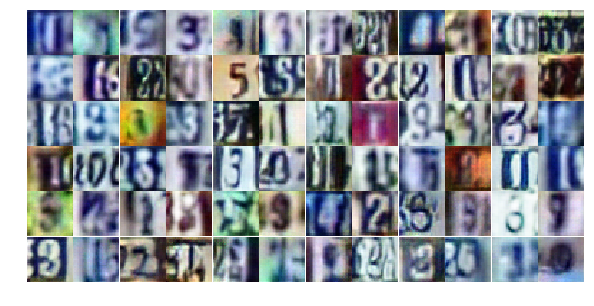

Epoch 22/25... Discriminator Loss: 0.5897... Generator Loss: 1.1872
Epoch 22/25... Discriminator Loss: 0.6951... Generator Loss: 0.9326
Epoch 22/25... Discriminator Loss: 0.5955... Generator Loss: 1.3060
Epoch 22/25... Discriminator Loss: 1.6308... Generator Loss: 0.3812
Epoch 22/25... Discriminator Loss: 0.4442... Generator Loss: 1.4287
Epoch 22/25... Discriminator Loss: 0.5495... Generator Loss: 1.2053
Epoch 22/25... Discriminator Loss: 0.5883... Generator Loss: 1.4336
Epoch 22/25... Discriminator Loss: 0.5260... Generator Loss: 1.3228
Epoch 22/25... Discriminator Loss: 0.2277... Generator Loss: 2.0636
Epoch 22/25... Discriminator Loss: 0.5154... Generator Loss: 1.3492


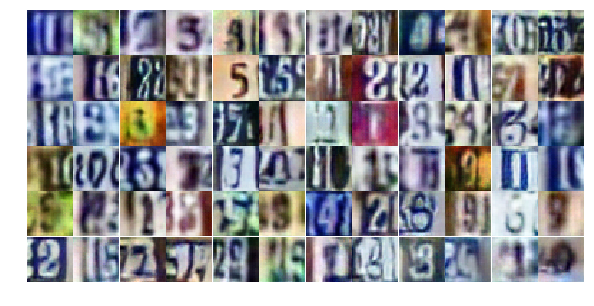

Epoch 22/25... Discriminator Loss: 1.4438... Generator Loss: 0.6371
Epoch 22/25... Discriminator Loss: 0.6516... Generator Loss: 1.1591
Epoch 23/25... Discriminator Loss: 0.4262... Generator Loss: 1.4156
Epoch 23/25... Discriminator Loss: 0.2824... Generator Loss: 2.0538
Epoch 23/25... Discriminator Loss: 0.2890... Generator Loss: 2.1297
Epoch 23/25... Discriminator Loss: 0.3368... Generator Loss: 1.7697
Epoch 23/25... Discriminator Loss: 0.3104... Generator Loss: 2.0779
Epoch 23/25... Discriminator Loss: 1.0384... Generator Loss: 3.5871
Epoch 23/25... Discriminator Loss: 0.7325... Generator Loss: 0.9615
Epoch 23/25... Discriminator Loss: 0.2552... Generator Loss: 1.9584


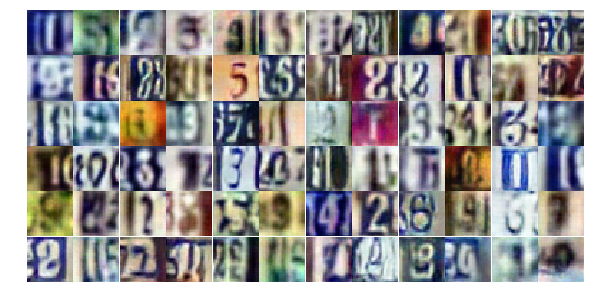

Epoch 23/25... Discriminator Loss: 0.7055... Generator Loss: 1.1358
Epoch 23/25... Discriminator Loss: 0.3539... Generator Loss: 1.7488
Epoch 23/25... Discriminator Loss: 1.1841... Generator Loss: 0.5528
Epoch 24/25... Discriminator Loss: 0.6698... Generator Loss: 1.0524
Epoch 24/25... Discriminator Loss: 0.3899... Generator Loss: 1.7929
Epoch 24/25... Discriminator Loss: 0.2730... Generator Loss: 1.8898
Epoch 24/25... Discriminator Loss: 0.3134... Generator Loss: 2.7680
Epoch 24/25... Discriminator Loss: 2.2102... Generator Loss: 0.2744
Epoch 24/25... Discriminator Loss: 0.4122... Generator Loss: 1.5336
Epoch 24/25... Discriminator Loss: 0.6208... Generator Loss: 1.1195


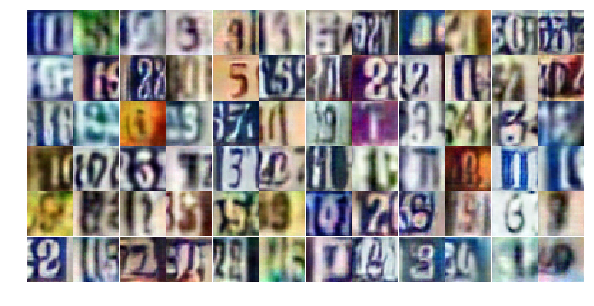

Epoch 24/25... Discriminator Loss: 0.9036... Generator Loss: 0.6947
Epoch 24/25... Discriminator Loss: 0.5144... Generator Loss: 1.2500
Epoch 24/25... Discriminator Loss: 0.7692... Generator Loss: 0.9362
Epoch 24/25... Discriminator Loss: 0.8170... Generator Loss: 0.8143
Epoch 24/25... Discriminator Loss: 0.5569... Generator Loss: 1.2276
Epoch 25/25... Discriminator Loss: 0.4218... Generator Loss: 2.3697
Epoch 25/25... Discriminator Loss: 0.5837... Generator Loss: 2.6431
Epoch 25/25... Discriminator Loss: 0.3631... Generator Loss: 1.7017
Epoch 25/25... Discriminator Loss: 0.6293... Generator Loss: 1.1861
Epoch 25/25... Discriminator Loss: 0.3886... Generator Loss: 1.6566


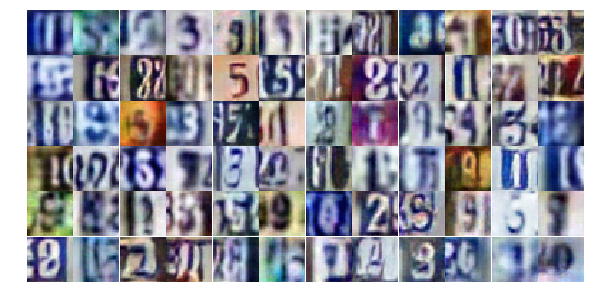

Epoch 25/25... Discriminator Loss: 0.4299... Generator Loss: 2.0352
Epoch 25/25... Discriminator Loss: 0.3771... Generator Loss: 1.5621
Epoch 25/25... Discriminator Loss: 0.6413... Generator Loss: 1.1009
Epoch 25/25... Discriminator Loss: 4.3787... Generator Loss: 0.0411
Epoch 25/25... Discriminator Loss: 0.7215... Generator Loss: 1.0746
Epoch 25/25... Discriminator Loss: 0.7566... Generator Loss: 0.9070


In [17]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, print_every=50, show_every=500, figsize=(10,5))

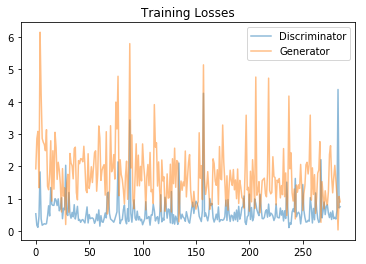

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

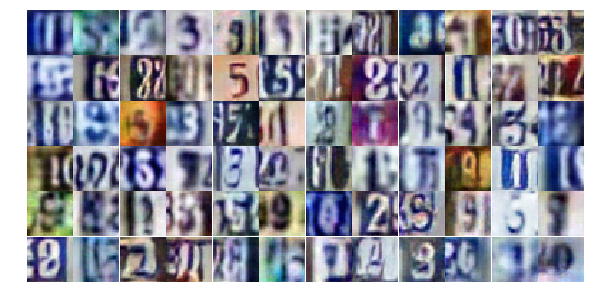

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))